In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal
import h5py
import matplotlib.pyplot as plt
import pandas as pd
from dingo.gw.noise.asd_dataset import ASDDataset
import yaml
import pycbc.psd
import numpy as np

In [2]:
font_value = 20

# Set global Matplotlib settings for a clean look without grids
plt.rcParams['axes.grid'] = False      # Disable grid lines for all axes
plt.rcParams['grid.color'] = 'none'    # Just in case, ensure grid color is invisible
# Set matplotlib to render LaTeX fonts
plt.rcParams.update({
    "mathtext.fontset" : "stix",
    "font.family" : "STIXGeneral",
    "axes.labelsize": font_value ,           # Font size for axis labels
    "axes.titlesize": font_value ,           # Font size for titles
    "font.size": font_value ,                # General font size
    "legend.fontsize": font_value ,          # Font size for legend
    "xtick.labelsize": font_value ,          # Font size for x-axis ticks
    "ytick.labelsize": font_value ,          # Font size for y-axis ticks
})

from matplotlib_inline.backend_inline import set_matplotlib_formats
# Enable retina display output in Jupyter
set_matplotlib_formats("retina")

In [ ]:
#ASD dataset settings:
f_min= 0         
f_max= 2048      
T= 2.0
delta_f = 1.0 / T
time_psd= 1024

In [21]:
# Load ET ASD data from text file
ET_ASD = pd.read_csv(
    "18213_ET10kmcolumns.txt",
    delimiter = ' ',
    header=None,
    usecols=[0, 3],         # first and last column
    names=["frequency", "PSD"]
)
# Calculate ASD from PSD
ET_ASD['ASD'] = np.sqrt(ET_ASD['PSD'])
ET_ASD = ET_ASD[ET_ASD["frequency"] <= f_max].reset_index(drop=True)

ET_ASD

,frequency,PSD,ASD
0,1.000000,3.480218e-33,5.899337e-17
1,1.003076,3.112909e-33,5.579345e-17
2,1.006161,2.787849e-33,5.280008e-17
3,1.009256,2.499719e-33,4.999719e-17
4,1.012360,2.243938e-33,4.737023e-17
...,...,...,...
2478,2018.839068,1.214832e-48,1.102194e-24
2479,2025.048731,1.222715e-48,1.105764e-24
2480,2031.277493,1.230654e-48,1.109349e-24
2481,2037.525414,1.238651e-48,1.112947e-24


In [ ]:
#resample asd to lenght fmax / delta_f + 1
f_new = np.arange(f_min, f_max + delta_f, delta_f)

PSD_new = np.interp(f_new, ET_ASD["frequency"], ET_ASD["PSD"])
ASD_new = np.sqrt(PSD_new)

ET_ASD_resampled = pd.DataFrame({
    "f": f_new,
    "h(f)": ASD_new
})

ET_ASD_resampled

,f,h(f)
0,0.0,5.899337e-17
1,0.5,5.899337e-17
2,1.0,5.899337e-17
3,1.5,2.644254e-19
4,2.0,1.006083e-21
...,...,...
4092,2046.0,1.116560e-24
4093,2046.5,1.116560e-24
4094,2047.0,1.116560e-24
4095,2047.5,1.116560e-24


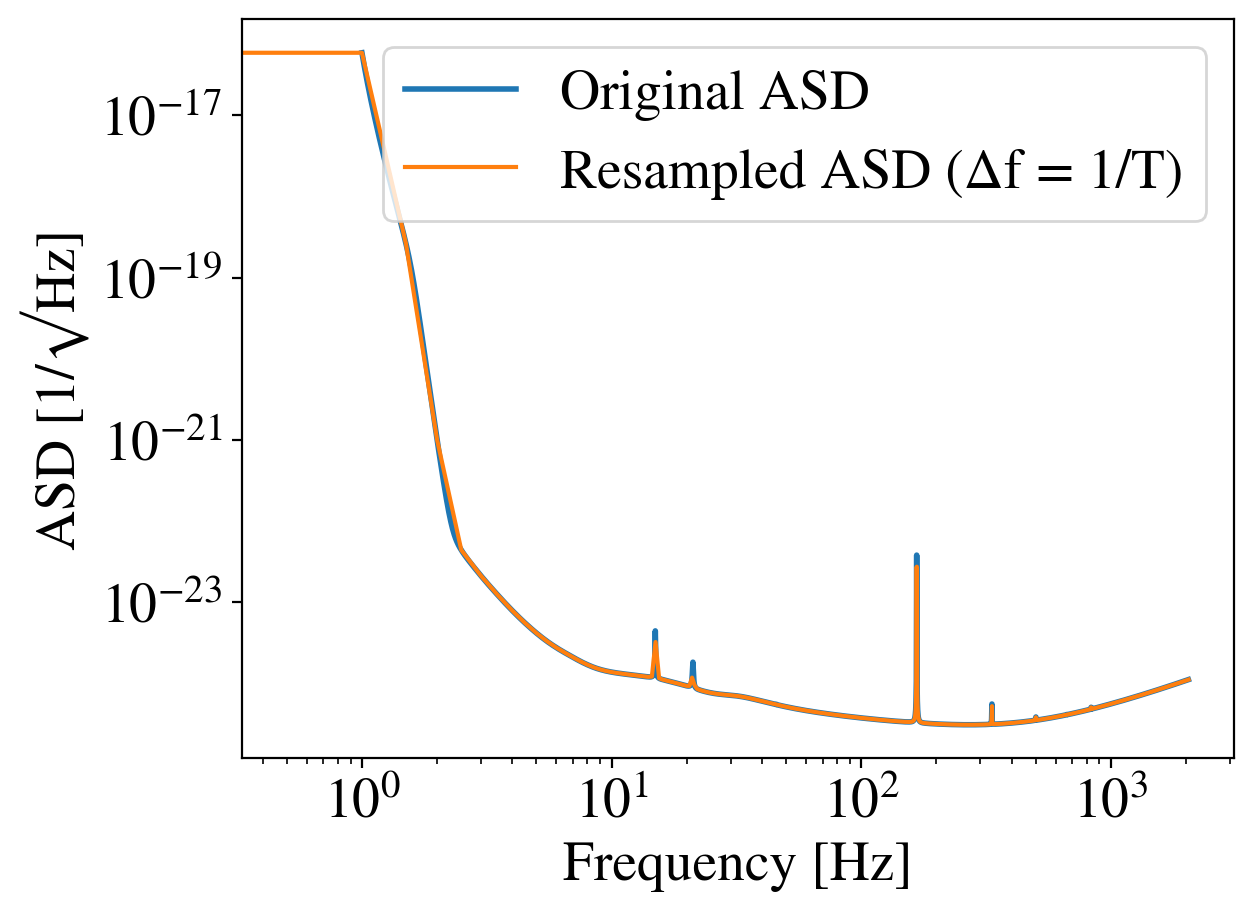

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(
    ET_ASD["frequency"],
    ET_ASD["ASD"],
    label="Original ASD",
    linewidth=2
)

plt.plot(
    ET_ASD_resampled["f"],
    ET_ASD_resampled["h(f)"],
    label="Resampled ASD (Δf = 1/T)"
)

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency [Hz]")
plt.ylabel("ASD [1/√Hz]")
plt.legend()
plt.grid(True)
plt.show()


In [33]:
#create hdf5 file 

settings = {
    "dataset_settings": {
        "T": T,                      # segment duration [s]
        "detectors": ["H1"],           # detector labels used as keys
        "f_s": 8192,                   # sampling rate [Hz]
        "num_psds_max": 1,             # number of PSD/ASD realizations
        "observing_run": None,
        "time_gap": 0,
        "time_psd": time_psd,          
        "window": {
            "roll_off": 0.4,
            "type": "tukey"
        }
    },
    "domain_dict": {
        "type": "FrequencyDomain",
        "delta_f": delta_f,
        "f_min": 6.0,
        "f_max": f_max
    }
}

ET_dict = {
    "settings": settings,
    "asds": {
        "H1": np.asarray(ET_ASD_resampled['h(f)']).reshape(1,int(f_max*T+1))
    },
    "gps_times": {
        "H1": 1126259462.391
    }
}

dataset = ASDDataset(dictionary=ET_dict)
dataset.to_file("asds_ET_working.hdf5")

#asd_dataset_ET_bilby = ASDDataset(file_name = 'asds_ET_working_ref_time_lower_max_freq_bilby.hdf5' )
asd_dataset_ET_bilby = ASDDataset(file_name = 'asds_ET_working.hdf5' )
print(f"Dingo version: {asd_dataset_ET_bilby.version}")
print("\nASD dataset\n" + "================\n")

print(f"Dataset size: {asd_dataset_ET_bilby.length_info}\n")
print(f"GPS times (min/max): {asd_dataset_ET_bilby.gps_info}")

print(
    "\nSettings\n"
    + "--------\n"
    + yaml.dump(
        asd_dataset_ET_bilby.settings,
        default_flow_style=False,
        sort_keys=False,
    )
)

Saving dataset to asds_ET_working.hdf5
Loading dataset from asds_ET_working.hdf5.
Dingo version: dingo=0.9.3

ASD dataset

Dataset size: {'H1': 1}

GPS times (min/max): {'H1': 1126259462.391}

Settings
--------
dataset_settings:
  T: 2.0
  detectors:
  - H1
  f_s: 8192
  num_psds_max: 1
  observing_run: null
  time_gap: 0
  time_psd: 1024
  window:
    roll_off: 0.4
    type: tukey
domain_dict:
  type: FrequencyDomain
  delta_f: 0.5
  f_min: 6.0
  f_max: 2048

